# RFM Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [31]:
orders = pd.read_csv('../data/olist_orders_dataset.csv')
customers = pd.read_csv('../data/olist_customers_dataset.csv')
items = pd.read_csv('../data/olist_order_items_dataset.csv')
payments = pd.read_csv('../data/olist_order_payments_dataset.csv')

# Merge untuk membentuk transaksi lengkap
df = orders.merge(customers, on='customer_id') \
           .merge(items, on='order_id') \
           .merge(payments, on='order_id')

## Tabel RFM

In [40]:
# Tanggal referensi (misal max order date)
reference_date = pd.to_datetime(df['order_purchase_timestamp']).max()

rfm = df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (reference_date - pd.to_datetime(x.max())).days,
    'order_id': 'nunique',
    'payment_value': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

## Clustering (K-Means)

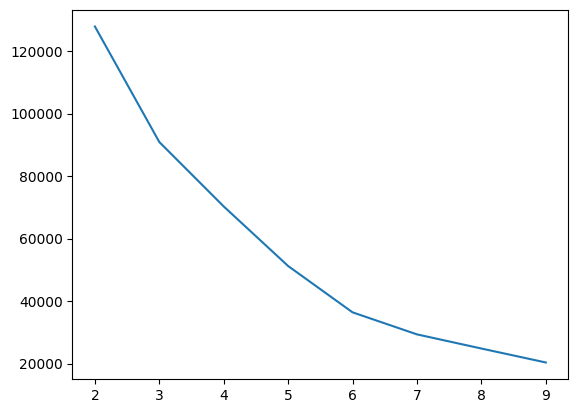

In [41]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
X_scaled = StandardScaler().fit_transform(X)

# Coba elbow method
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow
plt.plot(range(2, 10), inertia)

Dipilih k=6

<Axes: xlabel='Cluster', ylabel='Monetary'>

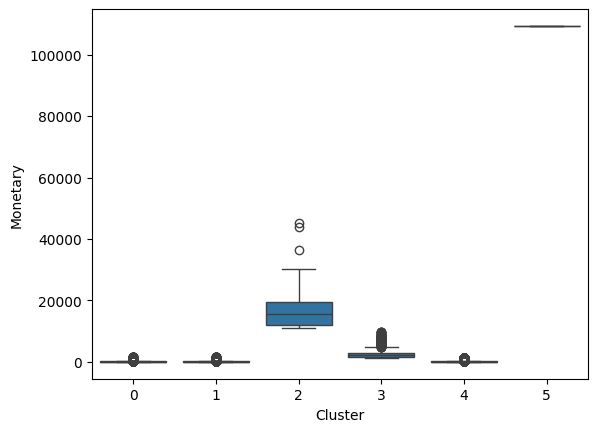

In [42]:
rfm['Cluster'] = KMeans(n_clusters=6, random_state=42).fit_predict(X_scaled)

sns.boxplot(x='Cluster', y='Monetary', data=rfm)

<Axes: xlabel='Cluster', ylabel='Recency'>

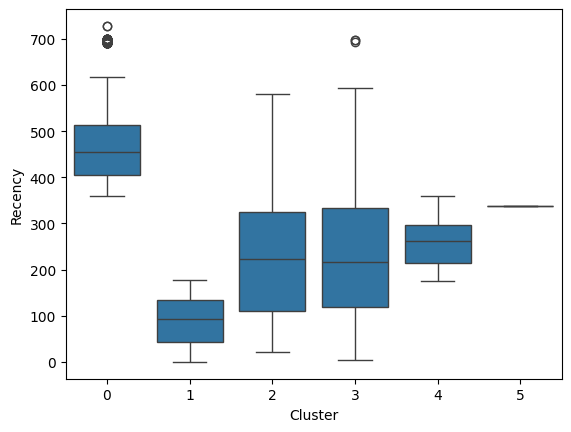

In [43]:
sns.boxplot(x='Cluster', y='Recency', data=rfm)

<Axes: xlabel='Cluster', ylabel='Frequency'>

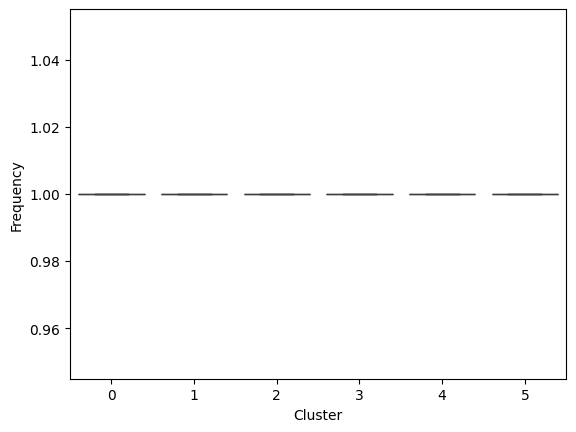

In [44]:
sns.boxplot(x='Cluster', y='Frequency', data=rfm)

In [45]:
# Evaluasi K-Means dengan silhouette score
kmeans_labels = rfm['Cluster']
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f'Silhouette Score K-Means: {kmeans_silhouette:.4f}')

Silhouette Score K-Means: 0.4868


In [46]:
# Simpan hasil
joblib.dump(kmeans, '../src/kmeans_rfm.pkl')
rfm.to_csv('../data/rfm_clustered.csv', index=False)

## Clustering (DBSCAN)

In [47]:
# Sampling data untuk mengurangi ukuran dataset
# Jika dataset terlalu besar, kita ambil sampel untuk DBSCAN
SAMPLE_SIZE = 50000
if len(rfm) > SAMPLE_SIZE:
    rfm_sample = rfm.sample(SAMPLE_SIZE, random_state=42)
    X_dbscan = rfm_sample[['Recency', 'Frequency', 'Monetary']]
    X_dbscan_scaled = StandardScaler().fit_transform(X_dbscan)
else:
    rfm_sample = rfm.copy()
    X_dbscan_scaled = X_scaled

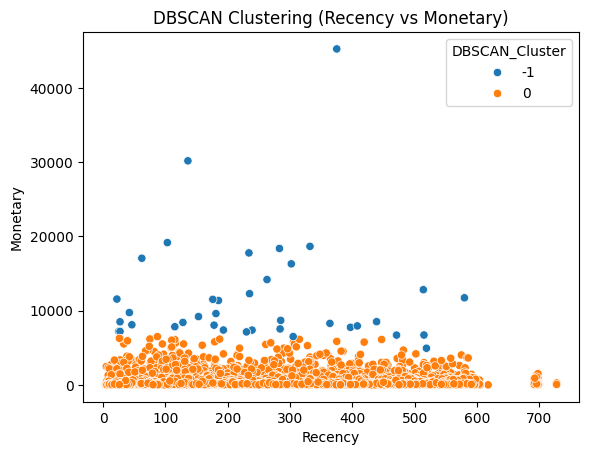

In [48]:
# DBSCAN membutuhkan data yang sudah diskalakan
# eps dan min_samples dapat di-tuning sesuai kebutuhan
dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm_sample['DBSCAN_Cluster'] = dbscan.fit_predict(X_dbscan_scaled)

# Visualisasi hasil DBSCAN pada Recency vs Monetary
dbscan_palette = sns.color_palette('tab10', n_colors=len(rfm_sample['DBSCAN_Cluster'].unique()))
sns.scatterplot(x='Recency', y='Monetary', hue='DBSCAN_Cluster', data=rfm_sample, palette=dbscan_palette)
plt.title('DBSCAN Clustering (Recency vs Monetary)')
plt.show()

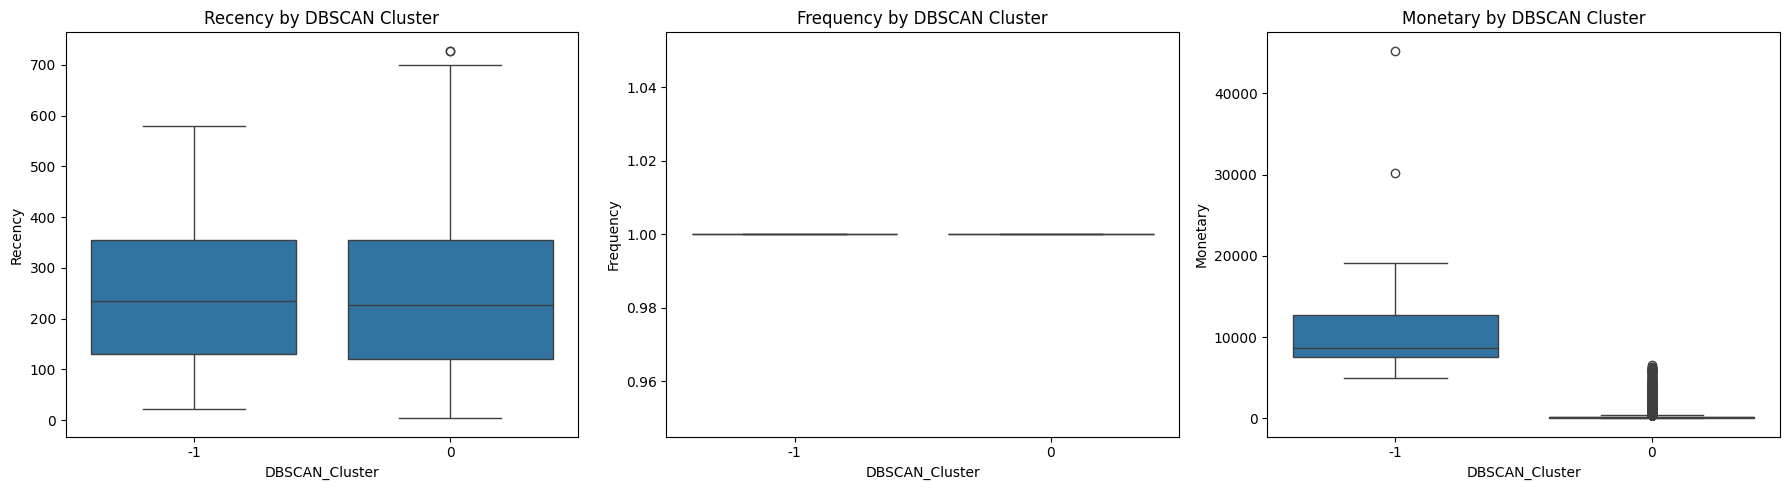

In [49]:
# Visualisasi distribusi cluster DBSCAN pada boxplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='DBSCAN_Cluster', y='Recency', data=rfm_sample, ax=axes[0])
axes[0].set_title('Recency by DBSCAN Cluster')
sns.boxplot(x='DBSCAN_Cluster', y='Frequency', data=rfm_sample, ax=axes[1])
axes[1].set_title('Frequency by DBSCAN Cluster')
sns.boxplot(x='DBSCAN_Cluster', y='Monetary', data=rfm_sample, ax=axes[2])
axes[2].set_title('Monetary by DBSCAN Cluster')
plt.tight_layout()
plt.show()

In [50]:
# Evaluasi DBSCAN dengan silhouette score
# Hanya dihitung jika jumlah cluster > 1 dan tidak semua -1 (noise)
dbscan_labels = rfm_sample['DBSCAN_Cluster']
if len(set(dbscan_labels)) > 1 and (set(dbscan_labels) - {-1}):
    dbscan_silhouette = silhouette_score(X_dbscan_scaled, dbscan_labels)
    print(f'Silhouette Score DBSCAN: {dbscan_silhouette:.4f}')
else:
    print('Silhouette Score DBSCAN tidak dapat dihitung (hanya 1 cluster atau semua noise).')

Silhouette Score DBSCAN: 0.9407


In [51]:
joblib.dump(dbscan, '../src/dbscan_rfm.pkl')
# Simpan hasil DBSCAN pada sample
dbscan_result = rfm_sample[['customer_id', 'Recency', 'Frequency', 'Monetary', 'DBSCAN_Cluster']]
dbscan_result.to_csv('../data/rfm_dbscan_clustered.csv', index=False)